# StackOverflow Modeling

This workbook demonstrates machine learning models for the project.  
For exploritory analysis and data pre-processing, please refer to   
https://github.com/yuqinouou/Springboard/blob/master/Capstone_Project/notebook/StackOverflow_EDA_Questions_Quality_Final.ipynb  



In [53]:
# load packages
import re
import string
import numpy as np
import pandas as pd
import itertools
import time

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from collections import Counter
from itertools import chain

from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from nltk.corpus import stopwords

In [2]:
%%time
# load dataset
file_path = "/Volumes/DockerDrive/"
df = pd.read_csv(file_path+"final_df.csv", index_col = "CreationDate", parse_dates=True)
df = df.drop('Unnamed: 0', axis=1)
df['TimeToFirstAnswer'] = pd.to_timedelta(df['TimeToFirstAnswer'])
df['TimeToFirstAcceptedAnswer'] = pd.to_timedelta(df['TimeToFirstAcceptedAnswer'])

CPU times: user 45.9 s, sys: 1.67 s, total: 47.5 s
Wall time: 45.8 s


## Model 1 - Feature Clustering

Here I try to run a clustering model to cateogrize question posts with features we have.

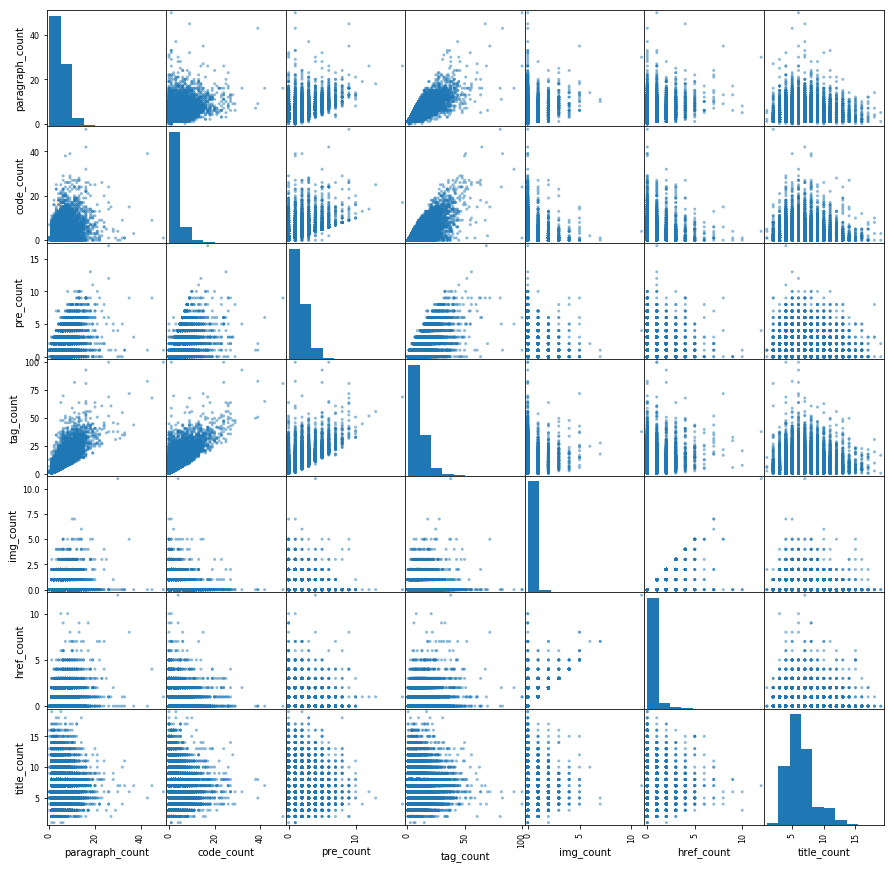

In [3]:
text_features = ['paragraph_count', 'code_count', 'pre_count', 'tag_count',
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']
pd.plotting.scatter_matrix(df[text_features[0:7]].sample(frac=0.01)[
    ['paragraph_count', 'code_count', 'pre_count', 'tag_count', 
     'img_count', 'href_count', 'title_count']
], figsize = (15, 15))
plt.show()

In [4]:
scaler = StandardScaler()
pca = PCA()
#pipeline = make_pipeline(scaler, model)
text_features = ['paragraph_count', 'code_count', 'pre_count', 
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']

In [5]:
df_transform = scaler.fit_transform(df[text_features])
pca.fit(df_transform)

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca.explained_variance_

array([2.08535806, 1.65745425, 1.26024877, 1.02894098, 0.7253371 ,
       0.4886375 , 0.43044201, 0.32358477])

In [7]:
df_transform = pca.transform(df_transform)

15692654.244360365
13617440.866535313
11516748.313590998
10249510.262117857
9631920.805553997
9082594.182015145
8603212.652835278
8177413.698145411
7771019.962256402
CPU times: user 32min 59s, sys: 4min 20s, total: 37min 19s
Wall time: 14min 4s


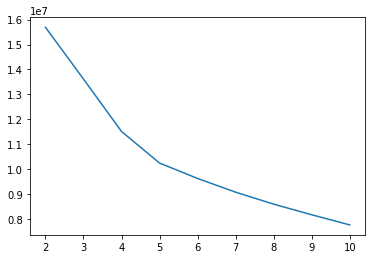

In [29]:
%%time
model_lst = []
inertia_lst = []
for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(df_transform)
    print(model.inertia_)
    model_lst.append(model)
    inertia_lst.append(model.inertia_)
    
plt.plot(range(2, 11), inertia_lst)

In [8]:
#cluster_model = model_lst[3]
cluster_model = KMeans(n_clusters=5)
cluster_model.fit(df_transform)
print(cluster_model.inertia_)

10249502.927345136


In [9]:
df['label'] = cluster_model.predict(df_transform)
df_summ = df[['label'] + text_features].groupby('label').mean()

In [15]:
df_summ.round(2).to_csv(file_path+'/plt/cov_table.csv')
df_summ.round(2)

,paragraph_count,code_count,pre_count,img_count,href_count,title_count,is_question,is_thankful
label,,,,,,,,
0,7.32,2.34,1.17,1.84,2.64,6.54,0.32,0.33
1,3.50,1.83,1.09,0.06,0.21,5.75,0.00,0.00
2,4.29,1.64,1.09,0.07,0.22,6.33,0.32,1.00
3,8.41,7.32,3.70,0.06,0.32,6.45,0.25,0.30
4,3.29,1.83,0.98,0.06,0.21,7.18,1.00,0.00


In [11]:
df['label'].value_counts()

1    847731
2    578392
4    498302
3    299060
0    101812
Name: label, dtype: int64

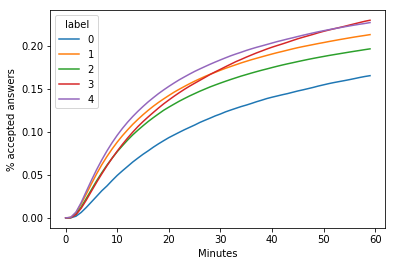

In [12]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster1.png')
plt.show()

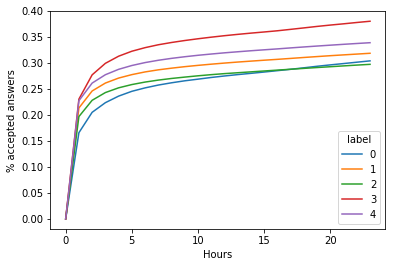

In [13]:
plot_data = pd.concat([df.groupby('label')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(hours = i))), [i])) for i in range(0, 24)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['label', 'Hours', 'Cumulative_Percentage']
plot_data.pivot(index='Hours', columns='label', values='Cumulative_Percentage').plot()
plt.ylabel('% accepted answers')
plt.savefig(file_path+'/plt/cluster2.png')
plt.show()

I chose five cluster since the magnitute for inertia declining slows down past 5 clusters. By checking mean values for each feature, we can get an idea of different styles of question posting:  
    0. wordy questions with a lot paragraphs and code chunks.  
    1. questions with narritive title and no thankful words.  
    2. questions with question title and no thankful words.  
    3. wordy questions with a lot paragraphs, less code chunks but more images and external links.  
    4. questions with thankful workds.  
    
Looking at time to first accepted answer, Level 0 category has different trend comparing with others. It takes a while to get a quality answer, but after 45 minute mark, it will be the most likely to get answered.  

Other categories has approximately the same shape of the curve, but different proportion of getting an answer, with Level 2 questions at the top, followed by Level 1 and Level 4. Level 3 is the least likely category.  

Comparing 1 to 2, it is more appreciated if the title is a question not a statement. Comparing 1,2 with 4, we got the feeling that it's actually unnecessary to be 'polite'. To me this is counter-intuitive, no one hates good manners.  

But I think this implies we missed some important features that confounded the result. For example, less-experienced programmers might be less confident in their narritive to the question, and being extremely polite, while it can also be associated with question quality issues such as duplications or unclear question description. Finally, when we look at Level 3, if a lot images and hyperlinks are added to a post, it actually does damage and less likely to get an answer. However, if we extend the time window to one day, Level 3 question will get more answers. It could be those questions are usually full of information, and takes longer to get an good answer, but there is nothing wrong with the question itself.


## Model 2 - Survival Analysis

The secondary model is to run a Cox-Regression to detect the magnitude for features to predict time-to-first-answer. But the caveat is also obvious - proportional hazard is a very strong assumption. Nevertheless, we try to run this model and see what the model fit looks like.  

In [14]:
import glmnet_python
from glmnet import glmnet
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

In [3]:
# get txt features
df_par = pd.get_dummies(pd.cut(df['paragraph_count'], [-1, 0, 5, 999], 
                               labels=['par0','par1_5','par6_']), drop_first=True).reset_index(drop=True).astype(float)
df_code = pd.get_dummies(pd.cut(df['code_count'], [-1, 0, 2, 999], 
                                labels=['code0','code1_2','code3_']), drop_first=True).reset_index(drop=True).astype(float)
df_pre = pd.get_dummies(pd.cut(df['pre_count'], [-1, 0, 2, 999], 
                               labels=['pre0','pre1_2','pre3_']), drop_first=True).reset_index(drop=True).astype(float)
df_tag = pd.get_dummies(pd.cut(df['tag_count'], [-1, 2, 10, 999], 
                               labels=['tag0_2','tag3_10','tag11_']), drop_first=True).reset_index(drop=True).astype(float)
df_img = pd.get_dummies(pd.cut(df['img_count'], [-1, 0, 1, 999], 
                               labels=['img0','img1','img2_']), drop_first=True).reset_index(drop=True).astype(float)
df_href = pd.get_dummies(pd.cut(df['href_count'], [-1, 0, 1, 999], 
                                labels=['href0','href1','href2_']), drop_first=True).reset_index(drop=True).astype(float)
df_title = pd.get_dummies(pd.cut(df['title_count'], [0, 3, 8, 999], 
                                 labels=['title1_3','title4_8','title9_']), drop_first=True).reset_index(drop=True).astype(float)

In [4]:
df_is = df[['is_question','is_thankful']].astype(float).reset_index(drop=True)

In [18]:
# get time features
df_wd = pd.DataFrame(df.index.weekday.isin([0,1,2,3,4]).astype(float))
df_wd.columns=['isweekday']

In [19]:
# get tag features top 30 tags
df.Tag_Doc[df.Tag_Doc.isna()] = ['NA']*5
cv = CountVectorizer(min_df=1000, max_features=30, token_pattern='\S+')
counts = cv.fit_transform(df.Tag_Doc)
df_posttag = pd.DataFrame(pd.SparseDataFrame(counts))
words = np.array(cv.get_feature_names()) 
df_posttag.columns = words
df_posttag = df_posttag.fillna(0)

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# get outcome measure, truncate to first hour.
t = df['TimeToFirstAcceptedAnswer'].copy()
t[t.isna()] = timedelta(days=999)
ind = (t <= timedelta(hours=24))
stime = np.minimum((t/timedelta(minutes=1)).astype(int), timedelta(hours=24)/timedelta(minutes=1))

In [8]:
df_y = pd.DataFrame({'time':stime, 'ind':ind})
df_y.head()

,time,ind
CreationDate,,
2017-01-01 00:00:04.523,1440.0,False
2017-01-01 00:00:39.710,70.0,True
2017-01-01 00:02:06.737,1440.0,False
2017-01-01 00:02:29.813,11.0,True
2017-01-01 00:03:28.577,1440.0,False


In [9]:
# create input matrix
x = pd.concat([df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag], axis=1, ignore_index=True)
col_lst = [d.columns for d in [df_par, df_code, df_pre, df_tag, df_img, df_href, df_title, df_is, df_wd, df_posttag]]
col_name = list(itertools.chain.from_iterable(col_lst))
x.columns = col_name
x['intercept'] = 1
y = df_y

In [21]:
x = np.array(x.astype(np.float64))
y = np.array(y.astype(np.float64))

In [15]:
fit = glmnet(x = x[0:1000].copy(), y = y[0:1000].copy(), family = 'cox')

OSError: dlopen(/Users/ouou/anaconda3/lib/python3.7/site-packages/glmnet_python/GLMnet.so, 6): Library not loaded: /usr/local/gfortran/lib/libquadmath.0.dylib
  Referenced from: /Users/ouou/anaconda3/lib/python3.7/site-packages/glmnet_python/GLMnet.so
  Reason: image not found

## Model 3 - Classification Model

We tried to fit a classification model to predict if a question will get answered within a day.

In [23]:
# get outcome class, <1h, 1h-1day, >1day
t = df['TimeToFirstAcceptedAnswer'].copy()
t[t.isna()] = timedelta(days=999)
t=t/timedelta(minutes=1)
#y = pd.cut(t, [-1, 60, 60*24, np.inf], labels=['Less than 1h', 'Less than 1d', 'Need more time'])
y = np.array(t<=60*24)

In [24]:
np.mean(y)

0.32683996925984077

In [43]:
#df = df.reset_index()
text_features = ['paragraph_count', 'code_count', 'pre_count', 'tag_count',
                 'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']

logdf = pd.DataFrame({'paragraph_count':np.log(1+df['paragraph_count']),
                      'code_count':np.log(1+df['code_count']),
                      'pre_count':np.log(1+df['pre_count']),
                      'tag_count':np.log(1+df['tag_count']),
                      'img_count':np.log(1+df['img_count']),
                      'href_count':np.log(1+df['href_count']),
                      'title_count':df['title_count'],
                      'is_question':df['is_question'],
                      'is_thankful':df['is_thankful'],
                     })

x = pd.concat([logdf, df_wd, df_posttag], axis=1, ignore_index=True)
col_lst = [d.columns for d in [logdf, df_wd, df_posttag]]
col_name = list(itertools.chain.from_iterable(col_lst))
x.columns = col_name
# x['intercept'] = 1
scaler = StandardScaler()
pca = PCA()
x_scaled = scaler.fit_transform(x)
x_transform = pca.fit_transform(x_scaled)

In [85]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_transform, y, test_size = 0.90, random_state = 123, stratify = y)

In [86]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    #"Linear SVM": SVC(),
    #"Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=20),
    "Decision Tree": tree.DecisionTreeClassifier(max_depth = 6),
    "Random Forest": RandomForestClassifier(n_estimators = 100, max_depth = 10, n_jobs=-1),
    #"Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": BernoulliNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),
    #"Gaussian Process": GaussianProcessClassifier()
}

from sklearn.metrics import roc_auc_score, f1_score, log_loss

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        
        t_diff = t_end - t_start
        
        #train_score = classifier.score(X_train, Y_train)
        #test_score = classifier.score(X_test, Y_test)
        
        #train_score = roc_auc_score(Y_train, classifier.predict_proba(X_train)[:,1])
        #test_score = roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])
        
        train_score = log_loss(Y_train, classifier.predict_proba(X_train)[:,1])
        test_score = log_loss(Y_test, classifier.predict_proba(X_test)[:,1])
        
        #train_score = f1_score(Y_train, classifier.predict(X_train))
        #test_score = f1_score(Y_test, classifier.predict(X_test))
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [87]:
dict_models = batch_classify(x_train, y_train, x_test, y_test, no_classifiers = 8)
display_dict_models(dict_models)

/Users/ouou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained Logistic Regression in 3.23 s
trained Decision Tree in 13.47 s
trained Random Forest in 429.01 s
trained Naive Bayes in 1.20 s


,classifier,train_score,test_score,train_time
3,Naive Bayes,0.641936,0.642507,1.196996
1,Decision Tree,0.612080,0.615737,13.470470
0,Logistic Regression,0.611102,0.611528,3.228716
2,Random Forest,0.591324,0.609245,429.013592
